#  **Project : Named Entity Recognition**

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.5 MB/s eta 0:00:00


# import python libraries

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
import spacy
from spacy import displacy
warnings.filterwarnings('ignore')
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle



# Loading the conll2003 dataset from datasets

In [ ]:

# Loading the conll2003 dataset from datasets
dataset = load_dataset("conll2003")

# Displaying the First sentence tokens and associated NER tags
first_sentence = dataset['train'][0]
print("Sentence:", first_sentence['tokens'])
print("NER Labels:", first_sentence['ner_tags'])

README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Sentence: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
NER Labels: [3, 0, 7, 0, 0, 0, 7, 0, 0]


# First example of this train Dataset of **Conll2003**

In [ ]:
dataset['train'][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

# Function to convert the dataset format to a DataFrame

In [ ]:
def dataset_to_dataframe(dataset):
    """
    Convert the dataset format to a DataFrame.

    Attributes :
      dataset: The dataset to convert.

    return : A DataFrame containing the dataset.= having column names as 'Word' and 'Tag'.
    """
    df_list = []
    for sentence in dataset:
        for word, ner in zip(sentence['tokens'], sentence['ner_tags']):
            df_list.append({'Word': word,  'Tag': ner})
    return pd.DataFrame(df_list)

# Convert training data to DataFrame
train_df = dataset_to_dataframe(dataset['train'])
train_df

,Word,Tag
0,EU,3
1,rejects,0
2,German,7
3,call,0
4,to,0
...,...,...
203616,three,0
203617,Swansea,3
203618,1,0
203619,Lincoln,3


# Map numeric tags to actual entity names


In [ ]:
tag_dict = {
    0: 'Outside',
    1: 'Beginning-PER',
    2: 'Inside-PER',
    3: 'Beginning-ORG',
    4: 'Inside-ORG',
    5: 'Beginning-LOC',
    6: 'Inside-LOC',
    7: 'Beginning-MISC',
    8: 'Inside-MISC'
}

train_df['Tag'] = train_df['Tag'].map(lambda x: tag_dict[x])  #convert the Ner tags into their original names
train_df.head(10)

,Word,Tag
0,EU,Beginning-ORG
1,rejects,Outside
2,German,Beginning-MISC
3,call,Outside
4,to,Outside
5,boycott,Outside
6,British,Beginning-MISC
7,lamb,Outside
8,.,Outside
9,Peter,Beginning-PER


In [ ]:
train_df.describe()

,Word,Tag
count,203621,203621
unique,23623,9
top,.,Outside
freq,7374,169578


# Analyze the distribution of entity tags

In [ ]:
tag_counts = train_df['Tag'].value_counts()
tag_counts

,count
Tag,
Outside,169578
Beginning-LOC,7140
Beginning-PER,6600
Beginning-ORG,6321
Inside-PER,4528
Inside-ORG,3704
Beginning-MISC,3438
Inside-LOC,1157
Inside-MISC,1155


# Plotting the frequency of different entities

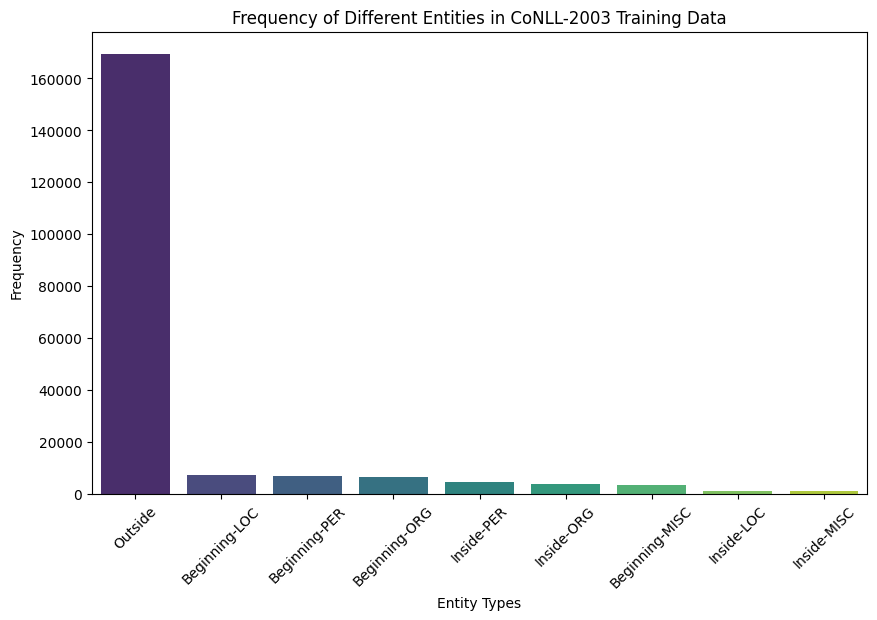

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=tag_counts.index, y=tag_counts.values, palette='viridis')
plt.title('Frequency of Different Entities in CoNLL-2003 Training Data')
plt.ylabel('Frequency')
plt.xlabel('Entity Types')
plt.xticks(rotation=45)
plt.show()

# Additional statistics

In [ ]:
num_sentences = len(dataset['train'])
num_tokens = len(train_df)
unique_tokens = train_df['Word'].nunique()

print(f"Number of sentences: {num_sentences}")
print(f"Number of tokens: {num_tokens}")
print(f"Number of unique tokens: {unique_tokens}")

Number of sentences: 14041
Number of tokens: 203621
Number of unique tokens: 23623


# Function to convert dataset into a more usable format

In [ ]:
def convert_into_sentences_and_labels(dataset):
  """
  This function is used for getting the all the sentences and their ner labels by sentence

  Attributes :
    dataset: The dataset that conatins the tokens and their ner labels

  return : sentences and labels
  """
  sentences, labels = [], []
  for data in dataset['train']:
      sentences.append(data['tokens'])
      labels.append(data['ner_tags'])

  return sentences, labels

sentences, labels = convert_into_sentences_and_labels(dataset)

In [ ]:
sentences[0],labels[0]

(['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
 [3, 0, 7, 0, 0, 0, 7, 0, 0])

# Find the maximum length of the sentence

In [ ]:
def max_length(sentences):
    """
    This function checks the maximum length of the sentence.

    Attributes :
      sentences: Contain the sentences with different - different lengths

    return : max_length of the sentence
    """
    max_length = max([len(sentence) for sentence in sentences])
    print("The maximum length of the sentence is : ", max_length)
    return max_length

max_len = max_length(sentences)

The maximum length of the sentence is :  113


# Tokenization


In [ ]:
def tokenize_sentences(sentences):
  """
  This function is used for tokenizing the sentences

  Attributes :
    sentences: The sentences that need to be tokenized

  return : tokenizer and encoded data
  """
  tokenizer = Tokenizer(oov_token = 'UNK')
  tokenizer.fit_on_texts(sentences)
  encoded_data = tokenizer.texts_to_sequences(sentences)

  return tokenizer, encoded_data

tokenize, x_encoded = tokenize_sentences(sentences)

In [ ]:
tag2idx = {tag: idx for idx, tag in enumerate(set([tag for sublist in labels for tag in sublist]))}
tag2idx

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}

In [ ]:
y_encoded = [[tag2idx[tag] for tag in doc] for doc in labels]
y_encoded[0]

[3, 0, 7, 0, 0, 0, 7, 0, 0]

# Pad sequences and split the dataset into train, test
Padding: The LSTM layers accept sequences of same length only. Therefore we will want to transform our list of token_sequences ('Word_idx') which is lists of integers into a matrix of shape (token_sequences, max_len). We can use any length as max_len. In this project we will be using length of the longest sequence as max_len. The sequences that are shorter than max_len are padded with a specified value at the end.
Import required packages


In [ ]:
def padding_sequence(data,max_length):
  """
  This function is used for padding the sentences

  Attributes :
    data = Encoded data that have to be padded
    max_length = Maximum length of the sentence

  return : padded data by convert into numpy array
  """

  pad_data = pad_sequences(data, maxlen = max_length, padding ='post')
  pad_data = np.array(pad_data)
  print("The shape of the padded data is : ", pad_data.shape)
  return pad_data

x_pad = padding_sequence(x_encoded, max_len)
y_pad = padding_sequence(y_encoded, max_len)

The shape of the padded data is :  (14041, 113)
The shape of the padded data is :  (14041, 113)


In [ ]:
def to_categorical_labels(data,classes):
    """
    This function converts the labels to categorical
    """
    categorical_data = [to_categorical(i, num_classes = classes) for i in data]
    categorical_data = np.array(categorical_data)
    print("The shape of the categorical data is : ", categorical_data.shape)
    return categorical_data

Y = to_categorical_labels(y_pad, len(tag2idx))

The shape of the categorical data is :  (14041, 113, 9)


In [ ]:
def split_data(x_data, y_data, test_size=0.1, random_state=42):
    """
    This function splits the data into training and testing sets
    """
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size= test_size, random_state = random_state)
    print("The shape of the training data is : ", x_train.shape)
    print("The shape of the testing data is : ", x_test.shape)
    print("The shape of the training labels is : ", y_train.shape)
    print("The shape of the testing labels is : ", y_test.shape)
    return x_train, x_test, y_train, y_test

X_train, X_test, Y_train, Y_test = split_data(x_pad, Y)

The shape of the training data is :  (12636, 113)
The shape of the testing data is :  (1405, 113)
The shape of the training labels is :  (12636, 113, 9)
The shape of the testing labels is :  (1405, 113, 9)


# Build Model Layout

Lets go through the process of building a neural network model with lstm layers. We are building a simple model with 4 layers.

- **Layer 1 - Embedding layer** : We will feed the padded sequences of equal length (113) to the embedding layer. Once the network has been trained, each token will get transformed into a vector of n dimensions.





- **Layer 2 - LSTM Layer** : An LSTM network is a recurrent neural network that has LSTM cell blocks in place of our standard neural network layers. These cells have various components called the input gate, the forget gate and the output gate.



- **Layer 3 - TimeDistributed  Layer** : We are dealing with Many to Many RNN Architecture where we expect output from every input sequence for example (a1 →b1, a2 →b2… an →bn) where a and b are inputs and outputs of every sequence. The TimeDistributeDense layers allow you to apply Dense(fully-connected) operation across every output over every time-step. If you don't use this, you would only have one final output.


In [ ]:
def build_model(input_dimension, output_dimension, input_len,total_output_classes):

    """
    This function builds the model for training
    Attributes :
      input_dimension = length of the vocabulory.
      output_dimension = Dimension of the output
      input_len = max_length of the sentence
      total_output_classes = total number of output classes we need to predict

    return : Builded model
    """

    model = Sequential()
    model.add(Embedding(input_dim=input_dimension, output_dim=output_dimension, input_length=input_len))
    model.add(LSTM(units = 100, return_sequences=True, recurrent_dropout=0.2))
    model.add(TimeDistributed(Dense(total_output_classes, activation='softmax')))
    model.build(input_shape=(None, input_len))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

lstm_model = build_model(len(tokenize.word_index)+1, 64, max_len, len(tag2idx))
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 113, 64)             │       1,344,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 113, 100)            │          66,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 113, 9)              │             909 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,411,613 (5.38 MB)

 Trainable params: 1,411,613 (5.38 MB)

 Non-trainable params: 0 (0.00 B)

# Fit the model

In [ ]:
history = lstm_model.fit(X_train, Y_train, batch_size = 32 , epochs = 5, validation_data=(X_test, Y_test))

Epoch 1/5
395/395 ━━━━━━━━━━━━━━━━━━━━ 177s 422ms/step - accuracy: 0.9622 - loss: 0.2456 - val_accuracy: 0.9794 - val_loss: 0.0674
Epoch 2/5
395/395 ━━━━━━━━━━━━━━━━━━━━ 125s 315ms/step - accuracy: 0.9814 - loss: 0.0577 - val_accuracy: 0.9862 - val_loss: 0.0451
Epoch 3/5
395/395 ━━━━━━━━━━━━━━━━━━━━ 167s 377ms/step - accuracy: 0.9885 - loss: 0.0379 - val_accuracy: 0.9904 - val_loss: 0.0355
Epoch 4/5
395/395 ━━━━━━━━━━━━━━━━━━━━ 171s 299ms/step - accuracy: 0.9930 - loss: 0.0265 - val_accuracy: 0.9924 - val_loss: 0.0292
Epoch 5/5
395/395 ━━━━━━━━━━━━━━━━━━━━ 141s 298ms/step - accuracy: 0.9958 - loss: 0.0177 - val_accuracy: 0.9934 - val_loss: 0.0244


In [ ]:
lstm_model.evaluate(X_test, Y_test)
y_pred = lstm_model.predict(X_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9936 - loss: 0.0232
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


#Check the relation between the Training loss and validation loss


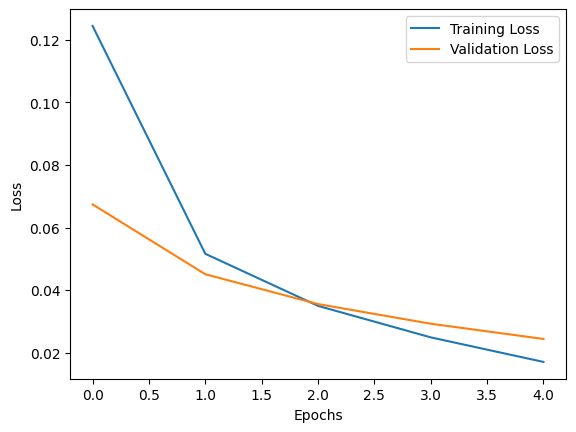

In [ ]:

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def inverse_categories(data):
  """
  This function is used for inverse transform of the categorical data and return the original data
  """
  new_data = np.argmax(data, axis=-1)
  return new_data

y_pred_arg = inverse_categories(y_pred)
y_test_arg = inverse_categories(Y_test)


y_pred_arg[50], y_test_arg[50]   # check a random example

(array([3, 0, 0, 1, 2, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]),
 array([3, 0, 0, 1, 2, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]))

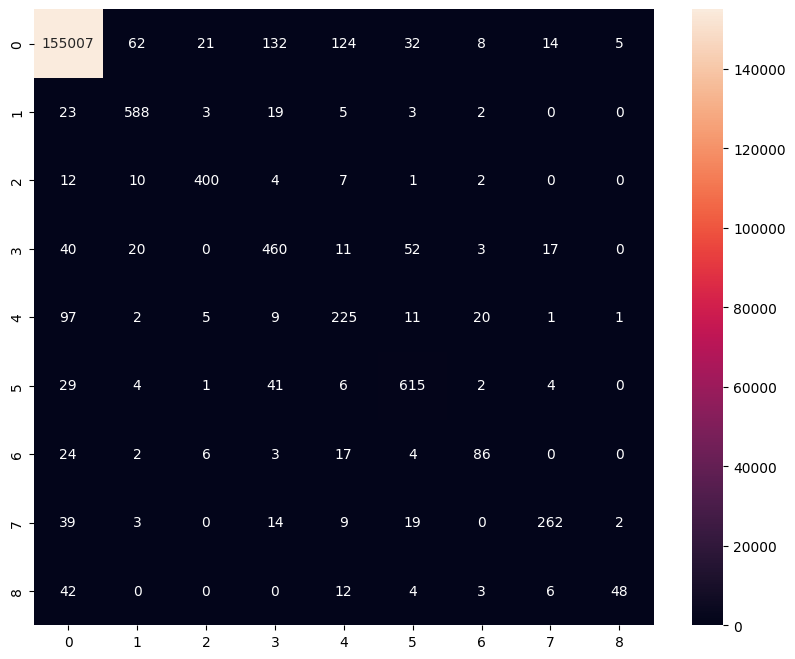

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    155405
           1       0.85      0.91      0.88       643
           2       0.92      0.92      0.92       436
           3       0.67      0.76      0.72       603
           4       0.54      0.61      0.57       371
           5       0.83      0.88      0.85       702
           6       0.68      0.61      0.64       142
           7       0.86      0.75      0.80       348
           8       0.86      0.42      0.56       115

    accuracy                           0.99    158765
   macro avg       0.80      0.76      0.77    158765
weighted avg       0.99      0.99      0.99    158765



In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test_arg.flatten(), y_pred_arg.flatten()), annot=True, fmt='g')
plt.show()
print(classification_report(y_test_arg.flatten(), y_pred_arg.flatten()))

# Reverse tag dictionary to map indices to tags

In [ ]:
idx2tag = {index : tag for tag, index in tag2idx.items()}

# For Model Prediction on Unseen Data

In [ ]:
def preprocess_sentence(sentences, tokenizer, max_len):
    """
    this funcion is used for Tokenize and pad sentences as done with the training data
    """
    seq = tokenizer.texts_to_sequences(sentences)
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post')
    seq_lengths = [len(s) for s in seq]  # Keep track of the original lengths before padding
    return padded_seq, seq_lengths


def decode_predictions(pred, seq_lengths, idx2tag):
    """
    This function is used for decode the prediction that has been come from the model and it convert into their original form
    """
    output = []
    for idx, pred_i in enumerate(pred):
        output_i = []
        length = seq_lengths[idx]  # Length of the actual sentence
        for j in range(length):  # Only iterate over the actual sentence length
            p = pred_i[j]
            p_i = np.argmax(p)
            output_i.append(idx2tag[p_i])
        output.append(output_i)
    return output

# Prepare new sentences for testing
new_sentences = [
    "Facebook and Google are big tech companies.",
    "Barack Obama was the president of the United States.",
    "I love to visit Paris and New York."
]

# Preprocess these new sentences and obtain original lengths
new_X, new_lengths = preprocess_sentence(new_sentences, tokenize, max_len)

# Predict using the model
predictions = lstm_model.predict(new_X)


# Decode predictions to get tag names instead of indices
decoded_predictions = decode_predictions(predictions, new_lengths, idx2tag)

# Print the results
for i, (sent, pred) in enumerate(zip(new_sentences, decoded_predictions)):
    print(f"Sentence {i+1}: {sent}")
    print(f"Predicted tags: {pred}")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Sentence 1: Facebook and Google are big tech companies.
Predicted tags: [3, 0, 3, 0, 0, 3, 0]

Sentence 2: Barack Obama was the president of the United States.
Predicted tags: [3, 4, 0, 0, 0, 0, 0, 5, 6]

Sentence 3: I love to visit Paris and New York.
Predicted tags: [0, 1, 0, 0, 5, 0, 5, 6]



# Load the Spacy model for displaying result's in better form

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
nlp = spacy.load("en_core_web_sm")
example = ["My name is Abhishek soni"]
example_seq, example_lengths = preprocess_sentence(example, tokenize, max_len)
predictions = lstm_model.predict(example_seq)
decoded_predictions = decode_predictions(predictions, example_lengths, idx2tag)

for i, (sent, pred) in enumerate(zip(example, decoded_predictions)):
    print(f"Sentence {i+1}: {sent}")
    print(f"Predicted tags: {pred}")
    print(f"Predicted labels : {list(map(lambda x : tag_dict[x],pred))}")

    doc = nlp(sent)
    entities = []
    start_char = 0

    for j, token in enumerate(doc):
        label = tag_dict[pred[j]]
        if label != 'Outside':
            entities.append({
                "start": start_char,
                "end": start_char + len(token.text),
                "label": label
            })
        start_char += len(token.text) + 1  # Add 1 for the space

    displacy.render([{"text": sent, "ents": entities, "title": "NER"}], style="ent", manual=True, jupyter=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Sentence 1: My name is Abhishek soni
Predicted tags: [0, 0, 0, 3, 4]
Predicted labels : ['Outside', 'Outside', 'Outside', 'Beginning-ORG', 'Inside-ORG']


In [ ]:
def update_model(model, new_sentences, new_labels, epochs):
    """
    Updates the existing NER model with new data.

    Attributes :
        model: The existing trained NER model.
        new_sentences: A list of new sentences for training.
        new_labels: A list of corresponding NER labels for the new sentences.
        epochs: The number of epochs to train the model with new data.

    return : Updated model
    """

    # Preprocess the new data
    new_X, new_lengths = preprocess_sentence(new_sentences, tokenize, max_len)
    new_y_encoded = [[tag2idx[tag] for tag in doc] for doc in new_labels]  # Encode new labels
    new_y_pad = padding_sequence(new_y_encoded, max_len)
    new_Y = to_categorical_labels(new_y_pad, len(tag2idx))

    # Fine-tune the model with the new data
    model.fit(new_X, new_Y, epochs=epochs, batch_size=32)



new_sentences = ["My name is Abhishek Soni and from rajasthan"]
new_labels = [[0, 0, 0, 1, 2, 0, 0, 5]]
update_model(lstm_model, new_sentences, new_labels, epochs=2)

The shape of the padded data is :  (1, 113)
The shape of the categorical data is :  (1, 113, 9)
Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9735 - loss: 0.0515
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 1.0000 - loss: 0.0131


In [ ]:
nlp = spacy.load("en_core_web_sm")
example = ["my name is Abhishek Soni and i from rajasthan","my name is anuj yadav and from Ahmedabad"]
example_seq, example_lengths = preprocess_sentence(example, tokenize, max_len)
predictions = lstm_model.predict(example_seq)
decoded_predictions = decode_predictions(predictions, example_lengths, idx2tag)

for i, (sent, pred) in enumerate(zip(example, decoded_predictions)):
    print(f"Sentence {i+1}: {sent}")
    print(f"Predicted tags: {pred}")
    print(f"Predicted labels : {list(map(lambda x : tag_dict[x],pred))}")

    doc = nlp(sent)
    entities = []
    start_char = 0

    for j, token in enumerate(doc):
        label = tag_dict[pred[j]]
        if label != 'Outside':
            entities.append({
                "start": start_char,
                "end": start_char + len(token.text),
                "label": label
            })
        start_char += len(token.text) + 1  # Add 1 for the space

    displacy.render([{"text": sent, "ents": entities, "title": "NER"}], style="ent", manual=True, jupyter=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Sentence 1: my name is Abhishek Soni and i from rajasthan
Predicted tags: [0, 0, 0, 1, 2, 0, 0, 0, 5]
Predicted labels : ['Outside', 'Outside', 'Outside', 'Beginning-PER', 'Inside-PER', 'Outside', 'Outside', 'Outside', 'Beginning-LOC']


Sentence 2: my name is anuj yadav and from Ahmedabad
Predicted tags: [0, 0, 0, 1, 2, 0, 0, 5]
Predicted labels : ['Outside', 'Outside', 'Outside', 'Beginning-PER', 'Inside-PER', 'Outside', 'Outside', 'Beginning-LOC']


# Save the tokenize, max_len, idx2tag and tag_dict into a dictionary


In [ ]:
model_data = {
    "tokenize": tokenize,
    "idx2tag": idx2tag,
    "tag_dict": tag_dict,
    "max_len" : max_len,
    "tag2idx" : tag2idx,
}
pickle.dump(model_data, open('model_data.pkl', 'wb'))

# Save the model

In [ ]:
lstm_model.save('ner_lstm_model.h5')

In [ ]:
with open('model_data.pkl', 'rb') as f:
    model_data = pickle.load(f)